# Segment medical images with MedSAM

perform inference with [MedSAM](https://twitter.com/BoWang87/status/1650690625317007361), a fine-tuned version of the SAM (segment-anything model) by Meta AI on the medical domain (thereby greatly improving its performance).

* [Original repo](https://github.com/bowang-lab/medsam)
* [Hugging Face docs](https://huggingface.co/docs/transformers/main/en/model_doc/sam).

Adapted from:
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Run_inference_with_MedSAM_using_HuggingFace_Transformers.ipynb

In [ ]:
!pip install -q jupyter_bbox_widget dataclasses-json supervision

# Get example image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Replace 'path_to_your_file' with the path of your file in Google Drive
# Replace 'destination_file_name' with the desired name of your file in the content folder
!cp "/content/drive/MyDrive/Brain MRI/Images_jpg/Training/glioma/Tr-glTr_0005.jpg" "/content/example_pic_1.jpg"

In [ ]:
file_path="/content/example_pic_1.jpg"

In [ ]:
from PIL import Image
import numpy as np

with Image.open(file_path) as img:
    image_array = np.array(img)

## Load model and processor

Next, let's load the SAM model and its corresponding processor. The model is available on the 🤗 hub here: https://huggingface.co/wanglab/medsam-vit-base.

In [ ]:
import torch
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")
model = SamModel.from_pretrained("wanglab/medsam-vit-base").to(device)

# Draw a Box


In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded# helper function that loads an image before adding it to the widget


In [ ]:
#run code below and then draw a box

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(file_path)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 102, 'y': 49, 'width': 297, 'height': 265, 'label': ''}]

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

input_boxes = box

In [ ]:
input_boxes

array([102,  49, 399, 314])

In [ ]:
import matplotlib.pyplot as plt

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(file_path, boxes):
    with Image.open(file_path) as img:
        raw_image = np.array(img)
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

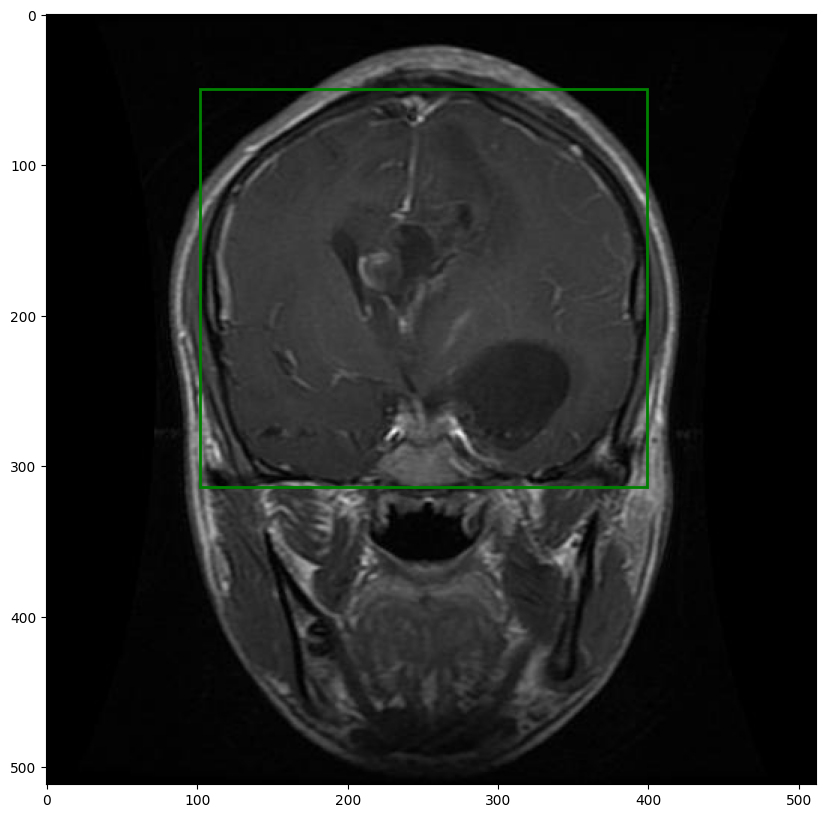

In [ ]:
show_boxes_on_image(file_path, [input_boxes])

The model is prompted to generate a segmentation mask inside the bounding box.

We can prepare the inputs for the model and perform a forward pass. We move the inputs and model to the GPU if it's available.

In [ ]:
# Converting the NumPy array to a Python list
input_boxes = input_boxes.tolist()

In [ ]:
input_boxes

[102, 49, 399, 314]

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# prepare image + box prompt for the model
inputs = processor(img, input_boxes=[[input_boxes]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [ ]:
model.to(device)

# forward pass
# note that the authors use `multimask_output=False` when performing inference
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [ ]:
outputs.pred_masks.shape

torch.Size([1, 1, 1, 256, 256])

Note that MedSAM was fine-tuned using a custom [DiceWithSigmoid loss](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L70), so we need to apply the appropriate [postprocessing](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/MedSAM_Inference.py#L67) here:

In [ ]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.3).astype(np.uint8)

In [ ]:
medsam_seg.shape

(256, 256)

In [ ]:
np.unique(medsam_seg)

array([0, 1], dtype=uint8)

In [ ]:
image_array.shape

(512, 512, 3)

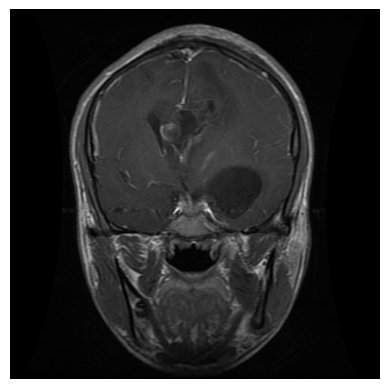

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Display the image
plt.imshow(image_array)
plt.axis('off')  # Turn off axis numbers
plt.show()


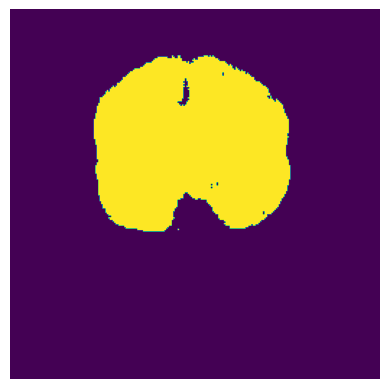

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Display the image
plt.imshow(medsam_seg)
plt.axis('off')  # Turn off axis numbers
plt.show()


## Visualize

Let's visualize the predicted mask:

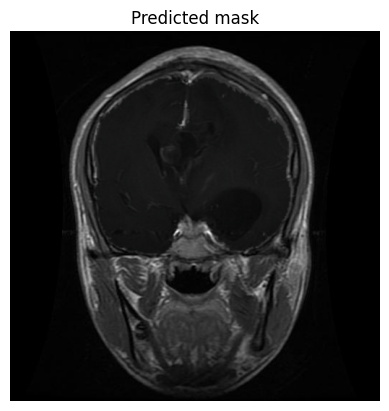

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

def show_mask(mask, image, ax, random_color=False):
    # Resize mask to match image dimensions
    mask_resized = resize(mask, (image.shape[0], image.shape[1]), preserve_range=True)

    if random_color:
        color = np.random.random(3)
    else:
        color = np.array([30/255, 144/255, 255/255])

    # Create a colored mask
    h, w = mask_resized.shape
    mask_colored = np.zeros((h, w, 3))
    for i in range(3):  # Apply color to the mask
        mask_colored[:, :, i] = mask_resized * color[i]

    # Overlay the mask on the image
    alpha = 0.6  # Transparency factor
    combined_image = image.astype(np.float32) * (1 - alpha * mask_resized.reshape(h, w, 1)) + mask_colored * alpha
    ax.imshow(combined_image.astype(np.uint8))

# Example usage
fig, ax = plt.subplots()
show_mask(medsam_seg, image_array, ax)
ax.set_title("Predicted mask")
ax.axis("off")
plt.show()


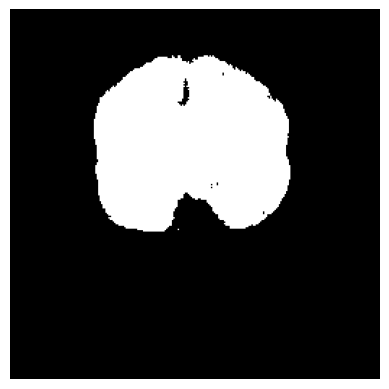

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

def cut_out_by_mask(image, mask):
    # Resize mask to match image dimensions
    mask_resized = resize(mask, (image.shape[0], image.shape[1]),
                          order=0,  # Nearest-neighbor interpolation
                          preserve_range=True, anti_aliasing=False).astype(bool)

    # Create an image with black background
    cut_out_image = np.zeros_like(image)

    # Set the masked area to white
    cut_out_image[mask_resized] = [255, 255, 255]  # White color

    return cut_out_image

cut_out = cut_out_by_mask(image_array.astype(np.uint8), medsam_seg)

# Display the cut-out image
plt.imshow(cut_out)
plt.axis('off')
plt.show()
